In [ ]:
# Brain MRI Tumor Segmentation

Objective: Compare Global Otsu Thresholding vs Sauvola Adaptive Thresholding  
for tumor segmentation in MRI images.

Dataset: Brain Tumor Segmentation Dataset (Kaggle)

Evaluation Metrics:  
- Dice Coefficient  
- Jaccard Index  

This notebook runs directly on Kaggle using the mounted dataset.

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_sauvola
from tqdm import tqdm

In [5]:
dataset_path = "/kaggle/input/datasets/nikhilroxtomar/brain-tumor-segmentation"

image_dir = os.path.join(dataset_path, "images")
mask_dir = os.path.join(dataset_path, "masks")

if not os.path.exists(image_dir):
    raise FileNotFoundError("Dataset not found. Please add it from Kaggle 'Add Data' section.")

image_files = sorted(os.listdir(image_dir))
print("Total images found:", len(image_files))

Total images found: 3064


In [6]:
def dice_score(pred, gt):
    pred = pred > 0
    gt = gt > 0
    intersection = np.logical_and(pred, gt).sum()
    return (2.0 * intersection) / (pred.sum() + gt.sum() + 1e-8)

def jaccard_score(pred, gt):
    pred = pred > 0
    gt = gt > 0
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return intersection / (union + 1e-8)

In [7]:
dice_otsu = []
dice_sauvola = []
jac_otsu = []
jac_sauvola = []

for file in tqdm(image_files):

    img_path = os.path.join(image_dir, file)
    mask_path = os.path.join(mask_dir, file)

    if not os.path.exists(mask_path):
        continue

    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Binarize ground truth
    _, gt_mask = cv2.threshold(gt_mask, 127, 255, cv2.THRESH_BINARY)

    # Slight smoothing
    image = cv2.GaussianBlur(image, (5, 5), 0)

    # -------- OTSU --------
    _, otsu_mask = cv2.threshold(
        image, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # -------- SAUVOLA --------
    thresh_sauvola = threshold_sauvola(image, window_size=25)
    sauvola_mask = (image > thresh_sauvola).astype(np.uint8) * 255

    # Morphological cleanup
    kernel = np.ones((3, 3), np.uint8)
    otsu_mask = cv2.morphologyEx(otsu_mask, cv2.MORPH_OPEN, kernel)
    otsu_mask = cv2.morphologyEx(otsu_mask, cv2.MORPH_CLOSE, kernel)

    sauvola_mask = cv2.morphologyEx(sauvola_mask, cv2.MORPH_OPEN, kernel)
    sauvola_mask = cv2.morphologyEx(sauvola_mask, cv2.MORPH_CLOSE, kernel)

    # Metrics
    dice_otsu.append(dice_score(otsu_mask, gt_mask))
    dice_sauvola.append(dice_score(sauvola_mask, gt_mask))

    jac_otsu.append(jaccard_score(otsu_mask, gt_mask))
    jac_sauvola.append(jaccard_score(sauvola_mask, gt_mask))

100%|██████████| 3064/3064 [02:06<00:00, 24.20it/s]


In [8]:
print("===== FINAL RESULTS =====\n")

print(f"Average Dice (Otsu):    {np.mean(dice_otsu):.4f}")
print(f"Average Dice (Sauvola): {np.mean(dice_sauvola):.4f}")

print(f"Average Jaccard (Otsu):    {np.mean(jac_otsu):.4f}")
print(f"Average Jaccard (Sauvola): {np.mean(jac_sauvola):.4f}")

print("\nInterpretation:")
if np.mean(dice_otsu) > np.mean(dice_sauvola):
    print("Otsu performs better because tumor intensity contrast is globally separable.")
else:
    print("Sauvola performs better due to local intensity adaptation.")

===== FINAL RESULTS =====

Average Dice (Otsu):    0.0705
Average Dice (Sauvola): 0.0454
Average Jaccard (Otsu):    0.0375
Average Jaccard (Sauvola): 0.0236

Interpretation:
Otsu performs better because tumor intensity contrast is globally separable.


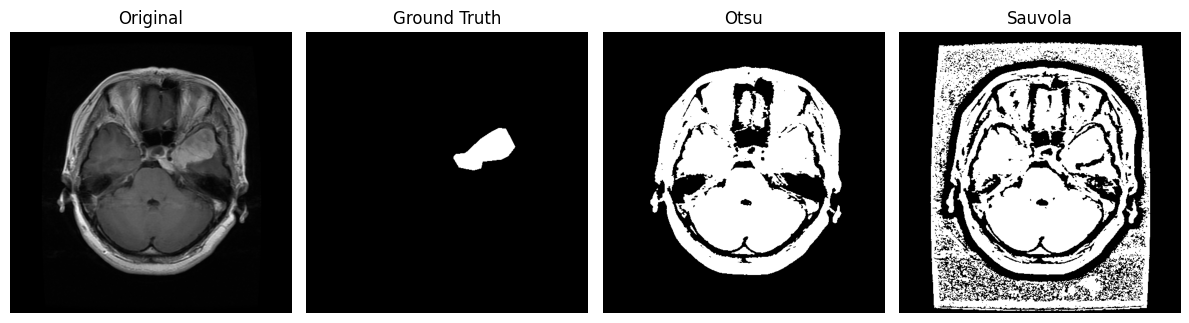

In [9]:
sample_idx = 0

img_sample = cv2.imread(
    os.path.join(image_dir, image_files[sample_idx]),
    cv2.IMREAD_GRAYSCALE
)

gt_sample = cv2.imread(
    os.path.join(mask_dir, image_files[sample_idx]),
    cv2.IMREAD_GRAYSCALE
)

_, gt_sample = cv2.threshold(gt_sample, 127, 255, cv2.THRESH_BINARY)

# Otsu
_, otsu_sample = cv2.threshold(
    img_sample, 0, 255,
    cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

# Sauvola
thresh_sauvola = threshold_sauvola(img_sample, window_size=25)
sauvola_sample = (img_sample > thresh_sauvola).astype(np.uint8) * 255

fig, axes = plt.subplots(1, 4, figsize=(12, 4))

axes[0].imshow(img_sample, cmap='gray')
axes[0].set_title("Original")

axes[1].imshow(gt_sample, cmap='gray')
axes[1].set_title("Ground Truth")

axes[2].imshow(otsu_sample, cmap='gray')
axes[2].set_title("Otsu")

axes[3].imshow(sauvola_sample, cmap='gray')
axes[3].set_title("Sauvola")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
## Conclusion

Otsu thresholding achieved higher Dice and Jaccard scores 
compared to Sauvola on this dataset.

This suggests that global thresholding works well for MRI slices 
where tumor intensity is clearly distinguishable from background.

Sauvola adaptive thresholding sometimes over-segments due to 
local intensity variations.